# Models

## Imports

In [1]:
import os
import sys

sys.path.append(os.getcwd())
os.chdir("..")

import pandas as pd

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 300)

In [2]:
import dill
import numpy as np
import matplotlib.pyplot as plt

import h2o
from h2o.automl import H2OAutoML

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, RocCurveDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression

import lightgbm as lgbm
from churn_pred.preprocessing.scaler import scaler_mapper
from churn_pred.training.utils import (
    predict_cls_lgbm_from_raw,
    predict_proba_lgbm_from_raw,
)
from churn_pred.preprocessing.label_encoder import LabelEncoder

# import tracemalloc
# import warnings
# from typing import Optional, Dict
# tracemalloc.start()

# Dataset

In [3]:
valid_size = 0.2
test_size = 0.5
random_state = 1
test_n_valid_combined = True

In [4]:
df_pd = pd.read_parquet("data/dataset_auxiliary_features_cleaned.parquet")
df_pd.head()

,CustomerId,CreditScore,Country,Gender,Age,Tenure,Balance (EUR),NumberOfProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Exited,CustomerFeedback_sentiment3,CustomerFeedback_sentiment5,Surname_Country,Surname_Country_region,Surname_Country_subregion,Country_region,Country_subregion,is_native,Country_hemisphere,Country_gdp_per_capita,Country_IncomeGroup,Surname_Country_gdp_per_capita,Surname_Country_IncomeGroup,working_class,stage_of_life,generation
0,15787619,844,France,Male,18,2,160980.03,1,0,0,145936.28,0,neutral,4 stars,Taiwan,Asia,Eastern Asia,Europe,Western Europe,0,northern,57594.03402,High income,32756.00000,None,working_age,teen,gen_z
1,15770309,656,France,Male,18,10,151762.74,1,0,1,127014.32,0,neutral,1 star,United States,Americas,Northern America,Europe,Western Europe,0,northern,57594.03402,High income,76329.58227,High income,working_age,teen,gen_z
2,15569178,570,France,Female,18,4,82767.42,1,1,0,71811.90,0,neutral,2 stars,Russian Federation,Europe,Eastern Europe,Europe,Western Europe,0,northern,57594.03402,High income,34637.76172,Upper middle income,working_age,teen,gen_z
3,15795519,716,Germany,Female,18,3,128743.80,1,0,0,197322.13,0,neutral,2 stars,Russian Federation,Europe,Eastern Europe,Europe,Western Europe,0,northern,66616.02225,High income,34637.76172,Upper middle income,working_age,teen,gen_z
4,15621893,727,France,Male,18,4,133550.67,1,1,1,46941.41,0,positive,1 star,Italy,Europe,Southern Europe,Europe,Western Europe,0,northern,57594.03402,High income,55442.07843,High income,working_age,teen,gen_z


In [5]:
target_col = "Exited"
id_cols = ["CustomerId"]
cat_cols = [
    "Country",
    "Gender",
    "HasCreditCard",
    "IsActiveMember",
    "CustomerFeedback_sentiment3",
    "CustomerFeedback_sentiment5",
    "Surname_Country",
    "Surname_Country_region",
    "Surname_Country_subregion",
    "Country_region",
    "Country_subregion",
    "is_native",
    "Country_hemisphere",
    "Country_IncomeGroup",
    "Surname_Country_IncomeGroup",
    "working_class",
    "stage_of_life",
    "generation",
]
cont_cols = df_pd.drop(
    columns=id_cols + cat_cols + [target_col]
).columns.values.tolist()

In [6]:
df_pd[cat_cols] = df_pd[cat_cols].astype(str)

check possible class imbalance

In [7]:
df_pd[target_col].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

# Preprocessing
* divide dataset into train, test, valid
* scale continuous columns by standard scaler(not needed for LightGBM but for other mdoels...)

In [8]:
df_train, df_valid = train_test_split(
    df_pd, test_size=valid_size, stratify=df_pd[target_col], random_state=random_state
)
df_valid, df_test = train_test_split(
    df_valid,
    test_size=test_size,
    stratify=df_valid[target_col],
    random_state=random_state,
)

df_train.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

scaler_mapper_def = {
    "cont_cols": StandardScaler,
    "cat_cols": None,
    "id_cols": None,
}
scaler = scaler_mapper(
    cont_cols=cont_cols,
    cat_cols=cat_cols,
    id_cols=[target_col] + id_cols,
    scaler_mapper_def=scaler_mapper_def,
)

df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)
df_valid_scaled = scaler.transform(df_valid)

## Logistic Regression

In [9]:
LR_clf = LogisticRegression(class_weight="balanced")
LR_clf.fit(
    df_train_scaled.drop(columns=[target_col] + id_cols + cat_cols),
    df_train_scaled[target_col],
)
LR_predicted = LR_clf.predict(
    df_test_scaled.drop(columns=[target_col] + id_cols + cat_cols)
)

print(
    "LR classification report :\n"
    + str(classification_report(df_test_scaled[target_col], LR_predicted))
)

LR classification report :
              precision    recall  f1-score   support

           0       0.91      0.71      0.79       796
           1       0.38      0.71      0.50       204

    accuracy                           0.71      1000
   macro avg       0.64      0.71      0.65      1000
weighted avg       0.80      0.71      0.73      1000



In [10]:
# which metrics am I focusing on? it is more importan to precisely predict non spenders or spenders?
from sklearn.metrics import f1_score

criterion = f1_score

threshold_score = []
for t in np.arange(0.2, 0.8, 0.01):
    # preds_bin = [int(p > t) for p in y_pred]
    preds_bin = (
        LR_clf.predict_proba(
            df_test_scaled.drop(columns=[target_col] + id_cols + cat_cols)
        )[:, 1]
        >= t
    ).astype(int)
    threshold_score.append(
        (t, criterion(df_test_scaled[target_col], preds_bin, average="weighted"))
    )

threshold_score = sorted(threshold_score, key=lambda x: x[1], reverse=True)
best_threshold, best_score = threshold_score[0][0], threshold_score[0][1]

print(f"The best threshold\n{best_threshold}\n, with score:\n{best_score}")

The best threshold
0.6100000000000003
, with score:
0.7973245061612856


In [11]:
y_onehot_test = pd.get_dummies(df_test_scaled[target_col]).values
y_score = LR_clf.predict_proba(
    df_test_scaled.drop(columns=[target_col] + id_cols + cat_cols)
)

micro_roc_auc_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    average=None,
)

micro_roc_auc_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    average="weighted",
)

In [12]:
print(f"Per class AUC:\n{micro_roc_auc_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_weighted}")

Per class AUC:
[0.76928761 0.76928761]
Weighted AUC:
0.7692876145433049


# H2O AutoML
**NOTE**:

[java is required](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/welcome.html#java-requirements): `sudo apt install openjdk-17-jdk`

In [13]:
# initialize H2O
h2o.init(log_dir="h2o_logs", log_level="WARN")

# read as h2o file
h2o_train = h2o.H2OFrame(df_train_scaled.drop(columns=id_cols))
h2o_valid = h2o.H2OFrame(df_valid_scaled.drop(columns=id_cols))
h2o_test = h2o.H2OFrame(df_test_scaled.drop(columns=id_cols))

# For binary classification, response should be a factor
h2o_train[target_col] = h2o_train[target_col].asfactor()
h2o_valid[target_col] = h2o_valid[target_col].asfactor()
h2o_test[target_col] = h2o_test[target_col].asfactor()

# Define AML task
aml = H2OAutoML(seed=random_state, max_runtime_secs=180)

# over/under sample for classification tasks
aml.balance_classes = True

# Run it
_ = aml.train(
    x=list(cont_cols + cat_cols),
    y=target_col,
    training_frame=h2o_train,
    leaderboard_frame=h2o_valid,
)

m = aml.get_best_model()

# Leaderboard, show and save
lb = h2o.automl.get_leaderboard(aml, extra_columns="ALL")
print(lb)
print(m.model_performance(h2o_valid))
predictions = m.predict(h2o_test)

# save results and model
# h2o.export_file(lb, path="h2o_logs/leaderboard.csv", force=True)
# MOJO is h2o version agnostic
# m.save_mojo("h2o_logs/bestmodel.zip")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.10" 2024-01-16; OpenJDK Runtime Environment (build 17.0.10+7-Ubuntu-122.04.1); OpenJDK 64-Bit Server VM (build 17.0.10+7-Ubuntu-122.04.1, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpaylgzon8
  JVM stdout: /tmp/tmpaylgzon8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpaylgzon8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 18 days
H2O_cluster_name:,H2O_from_python_unknownUser_3enaho
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
21:14:36.227: _train param, Dropping bad and constant columns: [Country_region, Country_IncomeGroup, Country_hemisphere]

████
21:14:47.43: _train param, Dropping bad and constant columns: [Country_region, Country_IncomeGroup, Country_hemisphere]

██
21:14:50.191: _train param, Dropping bad and constant columns: [Country_region, Country_IncomeGroup, Country_hemisphere]

██
21:14:58.843: _train param, Dropping unused columns: [Country_region, Country_IncomeGroup, Country_hemisphere]

█
21:14:59.823: _train param, Dropping bad and constant columns: [Country_region, Country_IncomeGroup, Country_hemisphere]

██
21:15:06.470: _train param, Dropping bad and constant columns: [Country_region, C

In [14]:
y_onehot_test = pd.get_dummies(df_test_scaled[target_col]).values
y_score = h2o.as_list(predictions.drop(["predict"])).values

micro_roc_auc_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    average=None,
)

micro_roc_auc_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    average="weighted",
)

/opt/conda/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [15]:
print(f"Per class AUC:\n{micro_roc_auc_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_weighted}")

Per class AUC:
[0.90083383 0.90083383]
Weighted AUC:
0.9008338259927087


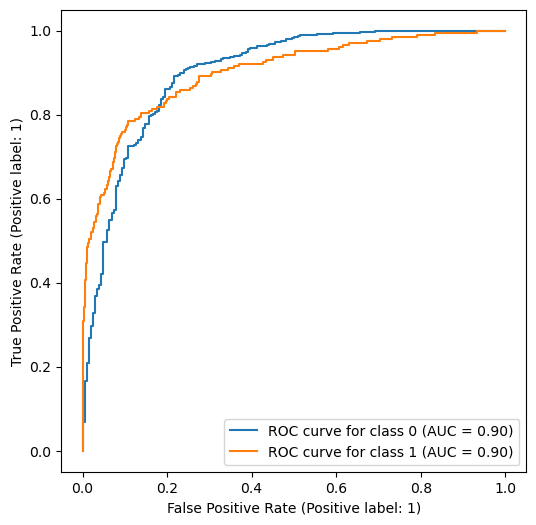

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
n_classes = 2

for class_id in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for class {class_id}",
        ax=ax,
        # plot_chance_level=(class_id == 2),
    )

In [19]:
print(
    "Classification report:\n{}".format(
        classification_report(df_test[target_col], h2o.as_list(predictions["predict"]))
    )
)

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       796
           1       0.66      0.76      0.71       204

    accuracy                           0.87      1000
   macro avg       0.80      0.83      0.81      1000
weighted avg       0.88      0.87      0.87      1000



/opt/conda/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


# LightGBM

In [20]:
config = {}
config["objective"] = "binary"

df_train_scaled_enc = df_train_scaled.copy()
df_valid_scaled_enc = df_valid_scaled.copy()
df_test_scaled_enc = df_test_scaled.copy()
lgb_cat_cols = cat_cols

label_encoder = LabelEncoder(lgb_cat_cols)
df_train_scaled_enc = label_encoder.fit_transform(df_train_scaled_enc)
df_valid_scaled_enc = label_encoder.transform(df_valid_scaled_enc)
df_test_scaled_enc = label_encoder.transform(df_test_scaled_enc)

lgbtrain = lgbm.Dataset(
    df_train_scaled_enc.drop(columns=[target_col] + id_cols),
    df_train_scaled_enc[target_col],
    categorical_feature=lgb_cat_cols,
    free_raw_data=False,
)
lgbvalid = lgbm.Dataset(
    df_valid_scaled_enc.drop(columns=[target_col] + id_cols),
    df_valid_scaled_enc[target_col],
    reference=lgbtrain,
    free_raw_data=False,
)
# Final TRAIN/TEST
ftrain = pd.concat([df_train_scaled_enc, df_valid_scaled_enc]).reset_index(drop=True)
flgbtrain = lgbm.Dataset(
    ftrain.drop(columns=[target_col] + id_cols),
    ftrain[target_col],
    categorical_feature=lgb_cat_cols,
    free_raw_data=False,
)
lgbtest = lgbm.Dataset(
    df_test_scaled_enc.drop(columns=[target_col] + id_cols),
    df_test_scaled_enc[target_col],
    categorical_feature=lgb_cat_cols,
    reference=flgbtrain,
    free_raw_data=False,
)

In [21]:
model = lgbm.train(
    config,
    lgbtrain,
    valid_sets=[lgbvalid],
    valid_names=[""],
    feval=None,
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


In [22]:
res = predict_cls_lgbm_from_raw(
    preds_raw=model.predict(lgbtest.data, raw_score=True),
    task="binary",
)

result = pd.DataFrame(
    {
        "predicted": res,
        "ground_truth": df_test[target_col].values,
    }
)

print(
    "Classification report:\n{}".format(
        classification_report(result["ground_truth"], result["predicted"])
    )
)

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       796
           1       0.76      0.58      0.66       204

    accuracy                           0.88      1000
   macro avg       0.83      0.77      0.79      1000
weighted avg       0.87      0.88      0.87      1000



In [23]:
y_onehot_test = pd.get_dummies(df_test_scaled[target_col]).values
y_score = predict_proba_lgbm_from_raw(
    preds_raw=model.predict(lgbtest.data),
    task="binary",
    binary2d=True,
)

micro_roc_auc_per_class = roc_auc_score(
    y_onehot_test,
    y_score,
    average=None,
)

micro_roc_auc_weighted = roc_auc_score(
    y_onehot_test,
    y_score,
    average="weighted",
)

print(f"Per class AUC:\n{micro_roc_auc_per_class}")
print(f"Weighted AUC:\n{micro_roc_auc_weighted}")

Per class AUC:
[0.89585797 0.89585797]
Weighted AUC:
0.8958579663020987
